<a href="https://colab.research.google.com/github/mario-ruoff/neural-network-learning/blob/main/cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Simple Convolutional Neural Network

#### Data Loader

In [34]:
%matplotlib inline
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
from IPython.display import display, clear_output

# Downloading MNIST dataset
print("Loading dataset...")
train_data = datasets.MNIST(
    root="dataset",
    train=True,
    download=True,
    transform=ToTensor(),
)
test_data = datasets.MNIST(
    root="dataset",
    train=False,
    download=True,
    transform=ToTensor(),
)

# Hyperparameters
learning_rate = 0.01
batch_size = 64
epochs = 5

# Set data loader
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=False)
print("Done")

Loading dataset...
Done


#### Network Setup

In [35]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")


class MarioNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 128),
            nn.ReLU(),
            nn.Linear(128, 10),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

Using cpu device


#### Network Training

MarioNet(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=10, bias=True)
  )
)
Epoch 1
-------------------------------
loss: 2.324306  [  128/60000]


loss: 2.088395  [12928/60000]
loss: 1.828341  [25728/60000]
loss: 1.409259  [38528/60000]
loss: 1.132189  [51328/60000]
Test Error: 
 Accuracy: 81.0%, Avg loss: 0.992399


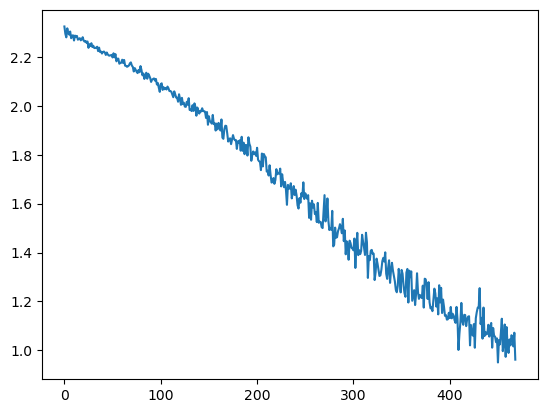

Epoch 2
-------------------------------
loss: 1.069638  [  128/60000]
loss: 0.853044  [12928/60000]
loss: 0.678390  [25728/60000]
loss: 0.575127  [38528/60000]
loss: 0.643015  [51328/60000]
Test Error: 
 Accuracy: 86.7%, Avg loss: 0.577917


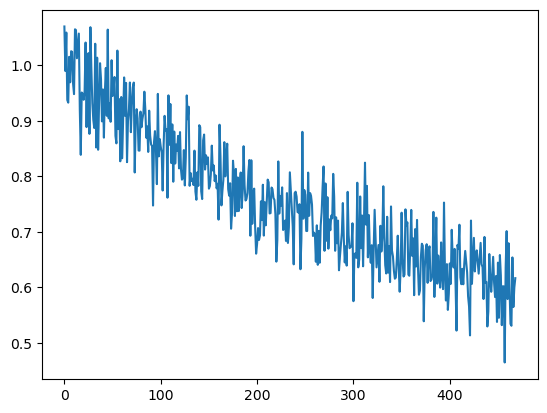

Epoch 3
-------------------------------
loss: 0.624227  [  128/60000]
loss: 0.688299  [12928/60000]
loss: 0.513480  [25728/60000]
loss: 0.457562  [38528/60000]
loss: 0.553338  [51328/60000]
Test Error: 
 Accuracy: 88.4%, Avg loss: 0.458225


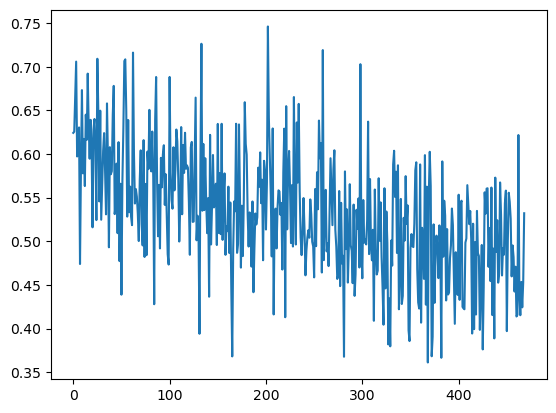

Epoch 4
-------------------------------
loss: 0.470472  [  128/60000]
loss: 0.477533  [12928/60000]
loss: 0.448390  [25728/60000]
loss: 0.480190  [38528/60000]
loss: 0.440511  [51328/60000]
Test Error: 
 Accuracy: 89.4%, Avg loss: 0.402767


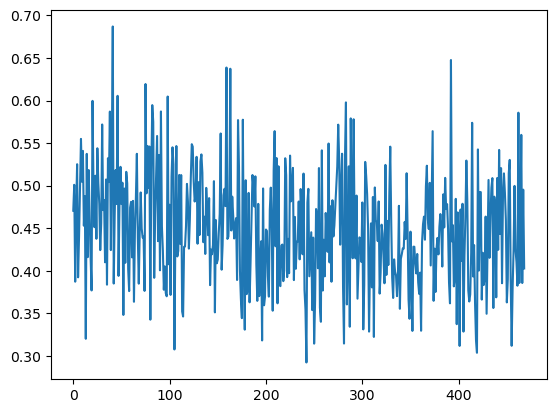

Epoch 5
-------------------------------
loss: 0.419281  [  128/60000]
loss: 0.461342  [12928/60000]
loss: 0.395175  [25728/60000]
loss: 0.399265  [38528/60000]
loss: 0.331564  [51328/60000]
Test Error: 
 Accuracy: 89.9%, Avg loss: 0.369546


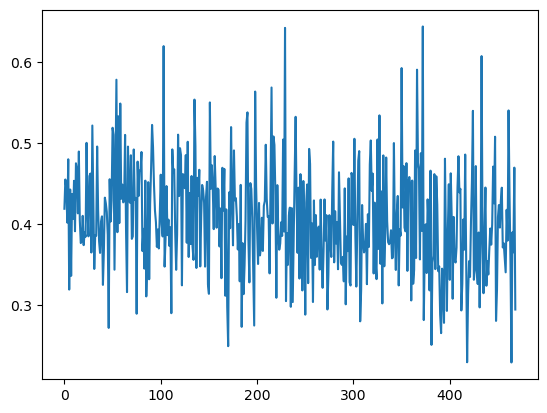

Done


In [36]:
# Train loop
def train_loop(dataloader, model, loss_fn, optimizer):
    train_losses = []
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        # Forward pass
        X, y = X.to(device), y.to(device)
        logits = model(X)
        loss = loss_fn(logits, y)
        train_losses.append(loss.item())

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        # Print progress
        if batch % 100 == 0:
            current = batch * batch_size + len(X)
            print(f"loss: {loss.item():>7f}  [{current:>5d}/{len(train_dataloader.dataset):>5d}]")

    return train_losses

# Test loop
def test_loop(dataloader, model, loss_fn):
    model.eval()
    test_loss, accuracy = 0, 0
    
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            logits = model(X)
            test_loss += loss_fn(logits, y).item()
            accuracy += (logits.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= len(dataloader)
    accuracy /= len(dataloader.dataset)
    print(f"Test Error: \n Accuracy: {(100*accuracy):>0.1f}%, Avg loss: {test_loss:>8f}")

model = MarioNet().to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
print(model)

for epoch in range(epochs):
    print(f"Epoch {epoch+1}\n-------------------------------")
    losses = train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loop(test_dataloader, model, loss_fn)
    plt.plot(losses)
    plt.show()

print("Done")

#### Test Network

In [37]:
test_loss = 0
accuracy = 0


test_loss /= len(test_dataloader)
accuracy /= len(test_dataloader.dataset)
print(f"Test loss: {test_loss}")
print(f"Accuracy: {accuracy * 100}%")

Test loss: 0.0
Accuracy: 0.0%


#### Analysis

In [38]:
index = 1
# pred_list = pred_probab.squeeze().tolist()
# y_pred = pred_probab.argmax(1)
# print(f"Predicted class: {y_pred.squeeze()}")
print("Label: ", labels[index], "- Prediction:", predictions[index].argmax(1))
plt.imshow(test_data.data[index].squeeze(), cmap=plt.cm.gray)
plt.show()
prediction = predictions[index].squeeze().tolist()
plt.bar(range(len(prediction)), prediction)

NameError: name 'labels' is not defined